In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

import datashader as ds
import datashader.transfer_functions as tf

%matplotlib inline
sns.set(color_codes=True)

## Load Data

In [2]:
path = '../datasets/preprocessed/'
stim   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
stim.drop(labels=['MotiveExpTimeSecs'], axis=1, inplace=True)
stim.head(3)

,Frame,Time,visible,speed,session_id
index,,,,,
0,0,0.000000,0,0.0,0
1,0,0.000000,0,0.0,0
2,1,0.004167,0,0.0,0


In [3]:
rat = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
rat.head(3)

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered
index,,,,,,,,,,
10,10,0.041667,-0.057007,0.071447,-0.050126,-0.630735,-0.770174,-0.077953,0,1
11,11,0.045833,-0.056929,0.071534,-0.050089,-0.630078,-0.771081,-0.071057,0,1
12,12,0.050000,-0.056841,0.071633,-0.050048,-0.629274,-0.772078,-0.063293,0,1


## Calculate Angle and Angular Velocity

### Calculate Angle (Theta)

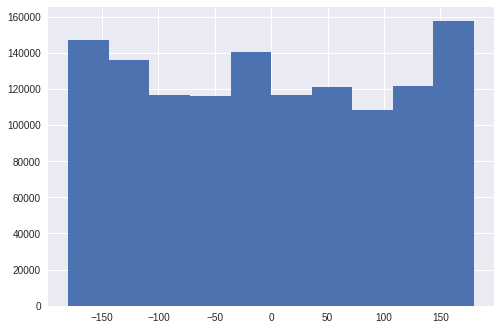

In [4]:
rat['Theta'] = np.degrees(np.arctan2(*(rat[['X_Ori', 'Z_Ori']].T / np.linalg.norm(rat[['X_Ori', 'Z_Ori']], axis=1)).values))
rat.Theta.hist();

### Calculate Angular Velocity (U)

In [5]:
def calculate_u(df):
    dfn = df[['Theta', 'Time']].diff()
#     pos = dfn['Theta'].rolling(window=50, center=False).mean()
    pos = dfn['Theta']
    pos_mask = pos > np.degrees(5.5)
    pos[pos_mask] = 360 - pos[pos_mask]

    neg_mask = pos < np.degrees(-5.5)
    pos[neg_mask] = 360 + pos[neg_mask]
    
    return pos / dfn['Time']

In [6]:
win_secs = 0.25
rat2 = pd.DataFrame()
for name, dd in rat.groupby('session_id'):
    
    dd['U'] = calculate_u(dd)
    dd['U_var'] = dd.U.rolling(window=int(win_secs * 240), center=False).std()
    
    rat2 = pd.concat([rat2, dd], axis=0, ignore_index=True)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Filter Out Bad Velocities
Strange values in some rows needed to be removed

Kept: 98.675%


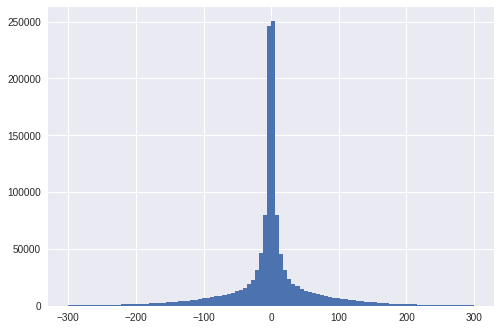

In [7]:
threshold = 300
plt.hist(rat2.U[np.abs(rat2.U) < threshold], bins=100);

print('Kept: {:.3%}'.format(np.mean(np.abs(rat2.U) < threshold)))

rat2 = rat2[np.abs(rat2.U) < threshold]

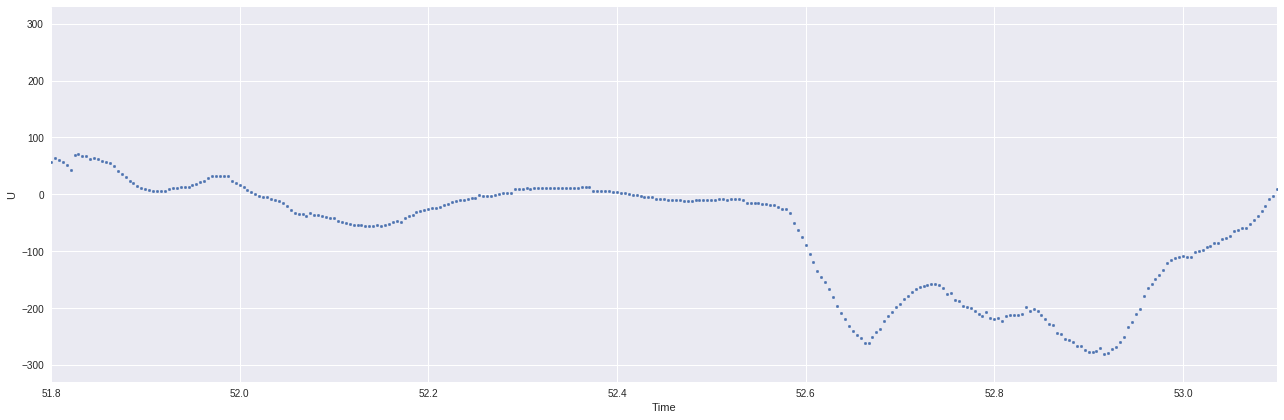

In [8]:
g = sns.FacetGrid(data=rat2[rat2['session_id']==1],  size=6, aspect=3, xlim=[51.8,53.1])
g.map(plt.scatter, 'Time', 'U', s=7.)


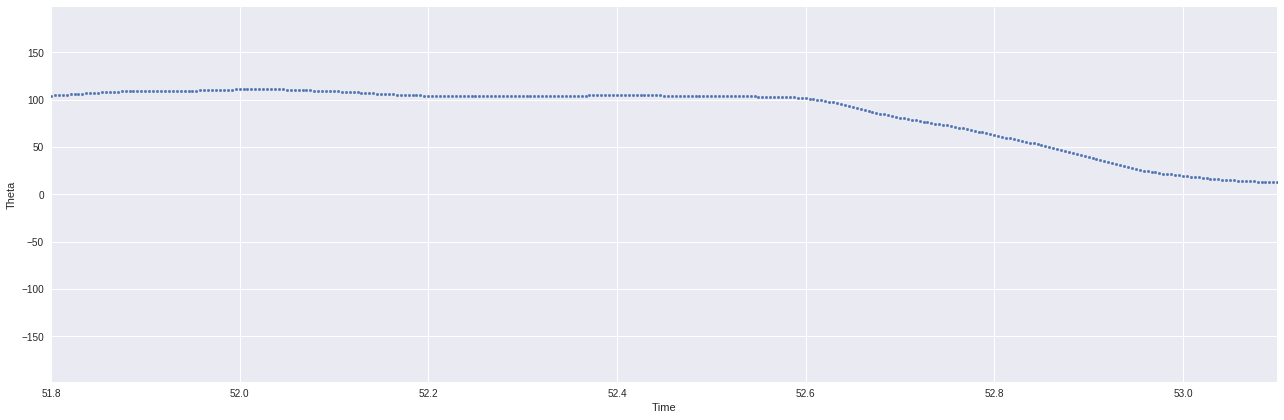

In [9]:
g = sns.FacetGrid(data=rat2[rat2['session_id']==1],  size=6, aspect=3, xlim=[51.8,53.1])
g.map(plt.scatter, 'Time', 'Theta', s=7.)

## Visualize Relationship between Data and Stimulus

In [10]:
rat_s = pd.merge(rat2, stim, on=['Frame', 'Time', 'session_id'])
rat_s.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var,visible,speed
0,11,0.045833,-0.056929,0.071534,-0.050089,-0.630078,-0.771081,-0.071057,0,1,-96.434320,146.698244,NaN,0,0.0
1,12,0.050000,-0.056841,0.071633,-0.050048,-0.629274,-0.772078,-0.063293,0,1,-95.743525,165.777747,NaN,0,0.0
2,13,0.054167,-0.056751,0.071736,-0.050003,-0.628491,-0.773053,-0.054848,0,1,-94.987501,181.431205,NaN,0,0.0
3,14,0.058333,-0.056654,0.071847,-0.049960,-0.627633,-0.774084,-0.045938,0,1,-94.186162,192.352190,NaN,0,0.0
4,15,0.062500,-0.056555,0.071962,-0.049917,-0.626826,-0.775066,-0.036472,0,1,-93.329980,205.467215,NaN,0,0.0


In [11]:
rat_sv = rat_s[rat_s['visible']==True]
rat_sv.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var,visible,speed
3263,4466,18.608335,-0.057211,0.265867,-0.031115,-0.610583,0.791649,-0.009823,0,1,-90.921690,9.436007,26.707928,1,0.0
3264,4467,18.612501,-0.057093,0.266152,-0.031153,-0.607553,0.794028,-0.009636,0,1,-90.908641,3.132097,26.705161,1,0.0
3265,4468,18.616668,-0.056979,0.266428,-0.031198,-0.604760,0.796192,-0.009562,0,1,-90.905872,0.664551,26.710839,1,28.0
3266,4469,18.620835,-0.056873,0.266707,-0.031251,-0.601908,0.798397,-0.009669,0,1,-90.920357,-3.476139,26.728943,1,28.0
3267,4470,18.625001,-0.056744,0.266939,-0.031295,-0.600480,0.799454,-0.010159,0,1,-90.969253,-11.736910,26.813039,1,28.0


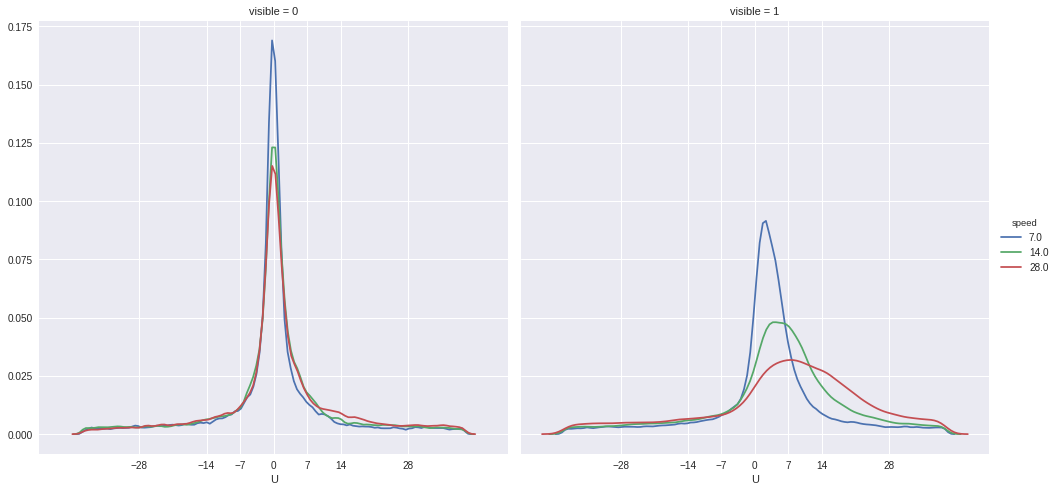

In [12]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed > 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

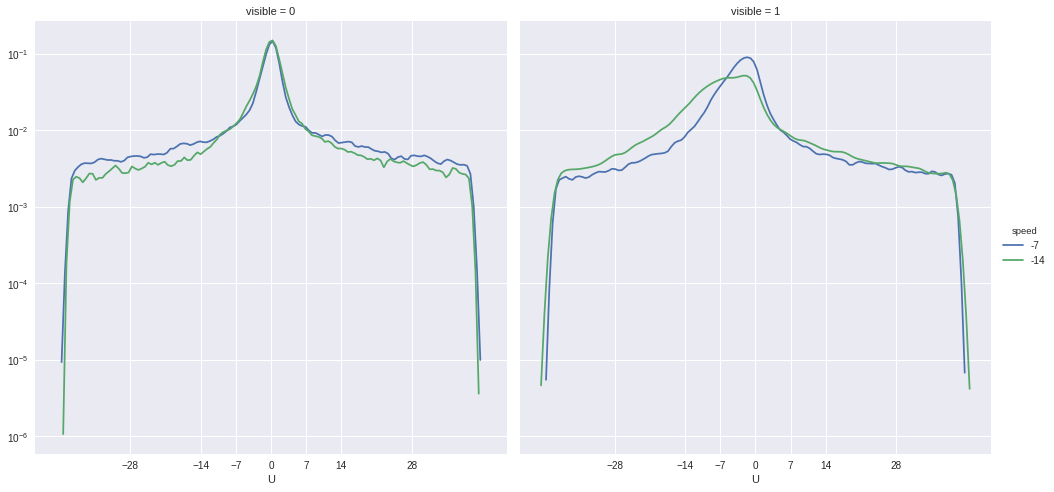

In [13]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', hue_order=[-7, -14], size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28], yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

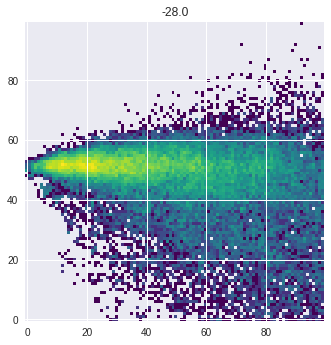

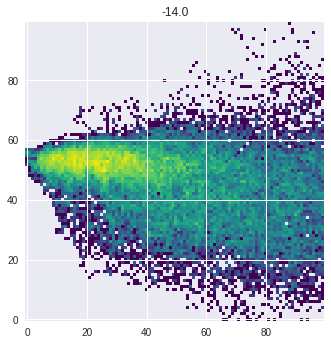

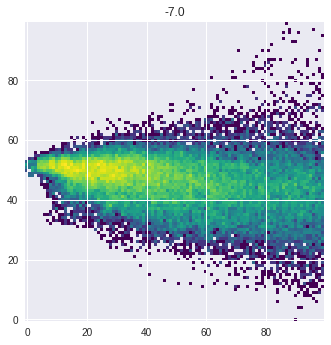

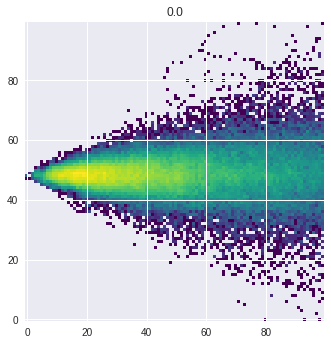

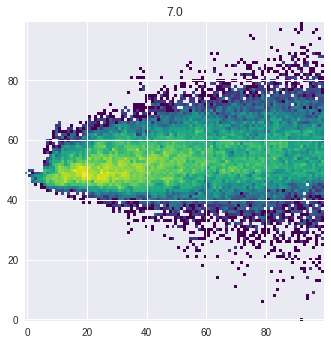

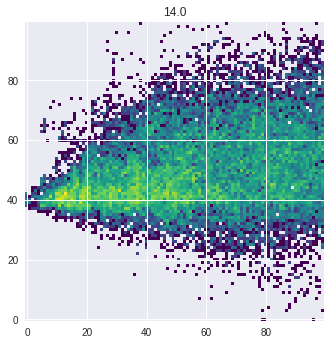

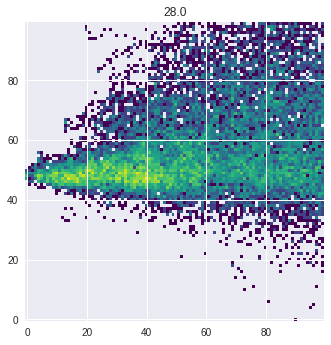

In [14]:
mask = (rat_s.U_var < 3) & (np.abs(rat_s.U) < 20)

for speed in sorted(np.unique(rat_s.speed)):
    temp_mask = mask & (rat_s.speed == speed)
    dd = rat_s[temp_mask].dropna()
    grid, x, y = np.histogram2d(dd.U, dd.U_var, bins=100)
    fig = plt.figure()
    plt.imshow(grid, origin='lower', cmap='viridis', norm=colors.LogNorm())
    plt.title(str(speed))